In [1]:
# Cell 1: INSTALL & IMPORT LIBRARIES

!pip install opendatasets

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import opendatasets as od

from google.colab import files
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.preprocessing import image

In [3]:
# Cell 2: DATA PREPARATION - DATA LOADING

DATASET_URL = "https://www.kaggle.com/datasets/zalando-research/fashionmnist"
od.download(DATASET_URL)

DATA_ROOT = "fashionmnist"
TRAIN_FILE = os.path.join(DATA_ROOT, "fashion-mnist_train.csv")
TEST_FILE  = os.path.join(DATA_ROOT, "fashion-mnist_test.csv")

os.path.exists(TRAIN_FILE), os.path.exists(TEST_FILE)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: najlaputrikaliandra
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist


100%|██████████| 68.8M/68.8M [00:00<00:00, 1.45GB/s]

(True, True)

In [4]:
# Cell 3: LOAD CSV DATA

train_df = pd.read_csv(TRAIN_FILE)
test_df  = pd.read_csv(TEST_FILE)

train_df.shape, test_df.shape

((60000, 785), (10000, 785))

In [5]:
# Cell 4: SPLIT PIXEL DATA (LABEL TIDAK DIGUNAKAN)

x_train = train_df.iloc[:, 1:].values
x_test  = test_df.iloc[:, 1:].values

print("Train shape:", x_train.shape)
print("Test shape :", x_test.shape)

Train shape: (60000, 784)
Test shape : (10000, 784)


In [6]:
# Cell 5: RESHAPE & NORMALIZATION

x_train = x_train.reshape(-1, 28, 28, 1).astype("float32") / 255.
x_test  = x_test.reshape(-1, 28, 28, 1).astype("float32") / 255.

print("After reshape:")
print("Train:", x_train.shape)
print("Test :", x_test.shape)

After reshape:
Train: (60000, 28, 28, 1)
Test : (10000, 28, 28, 1)


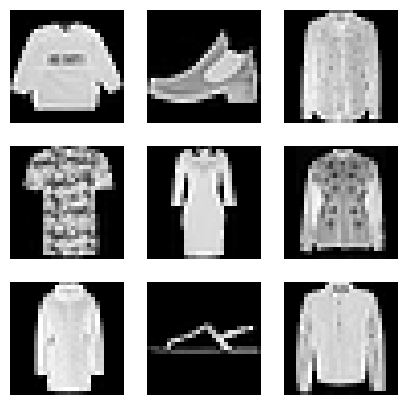

In [7]:
# Cell 6: VISUALISASI DATA ASLI

plt.figure(figsize=(5,5))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.axis('off')
plt.show()

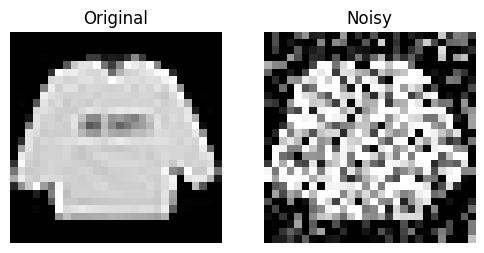

In [8]:
# Cell 7: ADD NOISE (DENOISING AUTOENCODER)

noise_factor = 0.4

x_train_noisy = x_train + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_train.shape
)

x_test_noisy = x_test + noise_factor * np.random.normal(
    loc=0.0, scale=1.0, size=x_test.shape
)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy  = np.clip(x_test_noisy, 0., 1.)


# Output visual

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(x_train[0].reshape(28,28), cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(x_train_noisy[0].reshape(28,28), cmap='gray')
plt.title("Noisy")
plt.axis('off')

plt.show()

In [9]:
# Cell 8: BUILD CNN AUTOENCODER

input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)

x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

# Decoder
x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2,2))(x)

x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)

decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Cell 9: COMPILE MODEL
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[BinaryAccuracy(name='accuracy')]
)

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Gunakan sebagian data saja (biar cepat di CPU)
x_train_small = x_train_noisy[:5000]
x_train_target = x_train[:5000]

x_val_small = x_test_noisy[:1000]
x_val_target = x_test[:1000]

print(x_train_small.shape, x_val_small.shape)

(5000, 28, 28, 1) (1000, 28, 28, 1)


In [12]:
# Cell 10: TRAIN MODEL

history = autoencoder.fit(
    x_train_small,
    x_train_target,
    epochs=10,
    batch_size=64,
    shuffle=True,
    validation_data=(x_val_small, x_val_target)
)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.4874 - loss: 0.0826 - val_accuracy: 0.5024 - val_loss: 0.0253
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 17s 211ms/step - accuracy: 0.5070 - loss: 0.0236 - val_accuracy: 0.5061 - val_loss: 0.0213
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.5077 - loss: 0.0204 - val_accuracy: 0.5062 - val_loss: 0.0195
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 202ms/step - accuracy: 0.5069 - loss: 0.0189 - val_accuracy: 0.5067 - val_loss: 0.0183
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 194ms/step - accuracy: 0.5092 - loss: 0.0178 - val_accuracy: 0.5070 - val_loss: 0.0181
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 196ms/step - accuracy: 0.5068 - loss: 0.0175 - val_accuracy: 0.5070 - val_loss: 0.0172
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 15s 195ms/step - accuracy: 0.5058 - loss: 0.0166 - val_accuracy: 0.5066 - val_loss: 0.0168
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 203ms/step - accuracy: 0.5092 - loss: 0.0164 - val_accu

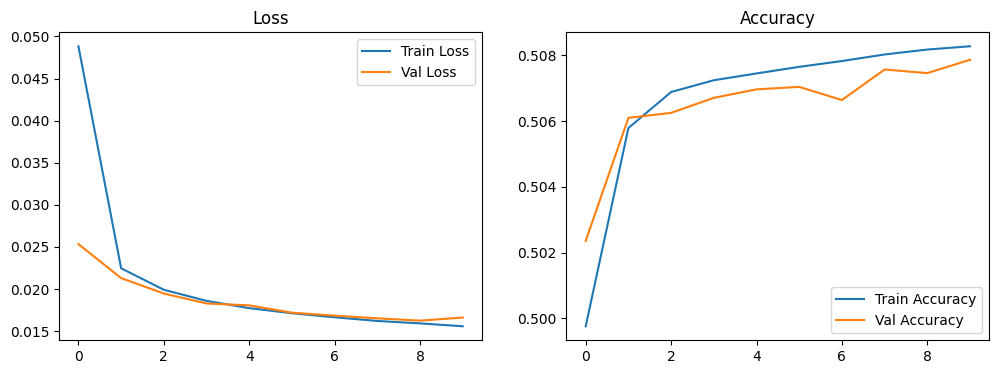

In [13]:
# Cell 11: TRAINING METRIC VISUALIZATION

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.legend()

plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step


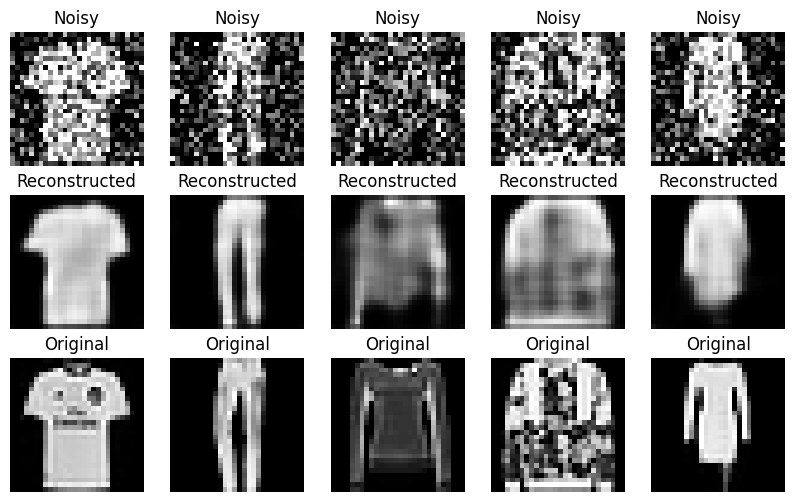

In [14]:
# Cell 12: INFERENCE - TEST DATA

decoded_imgs = autoencoder.predict(x_test_noisy)

# Visualisasi inference dari test data

n = 5
plt.figure(figsize=(10,6))

for i in range(n):
    plt.subplot(3,n,i+1)
    plt.imshow(x_test_noisy[i].reshape(28,28), cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    plt.subplot(3,n,i+1+n)
    plt.imshow(decoded_imgs[i].reshape(28,28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

    plt.subplot(3,n,i+1+2*n)
    plt.imshow(x_test[i].reshape(28,28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


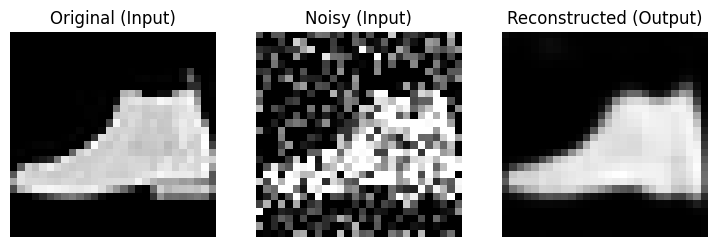

In [15]:
# Cell 13: MANUAL INPUT INFERENCE
idx = 100

custom_input = x_test[idx]
custom_input_noisy = x_test_noisy[idx]

custom_output = autoencoder.predict(
    custom_input_noisy.reshape(1,28,28,1)
)

# Visualisasi inference manual

plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.imshow(custom_input.reshape(28,28), cmap='gray')
plt.title("Original (Input)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(custom_input_noisy.reshape(28,28), cmap='gray')
plt.title("Noisy (Input)")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(custom_output.reshape(28,28), cmap='gray')
plt.title("Reconstructed (Output)")
plt.axis('off')

plt.show()

Saving pngtree-black-t-shirt-template-png-image_4293336.png to pngtree-black-t-shirt-template-png-image_4293336.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


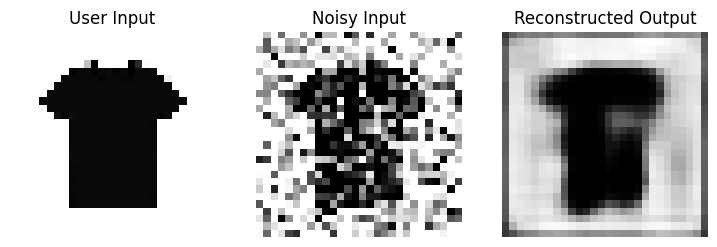

In [16]:
# Cell 14: USER IMAGE INFERENCE (EXTERNAL INPUT)
# Upload gambar
uploaded = files.upload()

# Ambil nama file
filename = list(uploaded.keys())[0]

# Preprocessing
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (28,28))
img = img / 255.0

# Tambahkan noise
noise = np.random.normal(0, 0.5, img.shape)
img_noisy = np.clip(img + noise, 0., 1.)

# Inference
reconstructed = autoencoder.predict(
    img_noisy.reshape(1,28,28,1)
)

# Visualisasi
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.imshow(img, cmap='gray')
plt.title("User Input")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img_noisy, cmap='gray')
plt.title("Noisy Input")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(reconstructed.reshape(28,28), cmap='gray')
plt.title("Reconstructed Output")
plt.axis('off')

plt.show()